<a href="https://colab.research.google.com/github/saeedzou/Deep-Learning-Project/blob/dev-saeed/Phase%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This block downloads and preprocesses the needed data for the project
!git clone https://github.com/XL2248/MSCTD
!cp MSCTD/MSCTD_data/ende/eng* .
!cp MSCTD/MSCTD_data/ende/ima* .
!cp MSCTD/MSCTD_data/ende/sent* .
!rm -rf MSCTD
!pip -q install --upgrade --no-cache-dir gdown
!gdown 1-43sQYxSCsCIxQjOCAS-H4dDI6c2zgi8
!gdown 1k-m84NIuOOTbXjn6ELwj1qBeH7jsN6IO
!gdown 1-0Gg-qpqJpNfLPU7DT81UaFgwu8DVn15
!unzip -q train_ende.zip
!unzip -q dev.zip
!unzip -q test.zip
!mv train_ende train
!mkdir train/image
!mkdir dev/image
!mkdir test/image
!mv train/*.jpg train/image
!mv dev/*.jpg dev/image
!mv test/*.jpg test/image
!mv *train.txt train
!mv *dev.txt dev
!mv *test.txt test

Cloning into 'MSCTD'...
remote: Enumerating objects: 1217, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 1217 (delta 13), reused 7 (delta 3), pack-reused 1190
Receiving objects: 100% (1217/1217), 102.24 MiB | 13.37 MiB/s, done.
Resolving deltas: 100% (616/616), done.
Updating files: 100% (934/934), done.
Downloading...
From: https://drive.google.com/uc?id=1-43sQYxSCsCIxQjOCAS-H4dDI6c2zgi8
To: /content/train_ende.zip
100% 2.90G/2.90G [00:27<00:00, 107MB/s]
Downloading...
From: https://drive.google.com/uc?id=1k-m84NIuOOTbXjn6ELwj1qBeH7jsN6IO
To: /content/dev.zip
100% 638M/638M [00:05<00:00, 113MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0Gg-qpqJpNfLPU7DT81UaFgwu8DVn15
To: /content/test.zip
100% 641M/641M [00:06<00:00, 98.4MB/s]


In [2]:
import numpy as np
import pandas as pd
import nltk
import nltk.tokenize as tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.io import read_image
from torchvision import transforms
import json
import cv2
from pycocotools.coco import COCO
import os
import string
import re
import gc
import random
import matplotlib.pyplot as plt
!pip install -q transformers
import seaborn as sns
from transformers import BertTokenizer
from transformers import BertModel
from PIL import Image
!pip install -q timm
import timm
from tqdm import tqdm
!pip install -q facenet_pytorch
from facenet_pytorch import MTCNN, InceptionResnetV1

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 75.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.5 MB/s eta 0:00:00


In [3]:
class MSCTD(Dataset):
    """
    :param root: root path of the dataset
    :param split: train, dev, test
    :param image_transform: transform for image
    :param text_transform: transform for text
    :param sentiment_transform: transform for sentiment
    :param has_data: dict, whether the dataset has image, text
    :param text_path: path of the text file
    :param image_path: path of the image folder
    :param sentiment_path: path of the sentiment file
    :param image_index_path: path of the image index file

    :return: combination of image, sentiment, text, image_index

    Example:
    >>> from torchvision import transforms
    >>> image_transform = transforms.Compose([
    >>>     transforms.Resize((640, 1280)),
    >>>     transforms.Lambda(lambda x: x.permute(1, 2, 0))
    >>> ])
    >>> text_transform = None
    >>> sentiment_transform = None
    >>> dataset = MSCTD(root='data', split='train', image_transform=image_transform,
    >>>                 text_transform=text_transform, sentiment_transform=sentiment_transform)
    >>> image, text, sentiment = dataset[0]

    """
    def __init__(self, root, split, image_transform=None, text_transform=None, sentiment_transform=None,
                 has_data={'image': True, 'text': True}, text_path=None, image_path=None, sentiment_path=None,
                 image_index_path=None):
        data_path = os.path.join(root, split)
        default_path = {
            'text': os.path.join(data_path, 'english_' + split + '.txt'),
            'image': os.path.join(data_path, 'image'),
            'sentiment': os.path.join(data_path, 'sentiment_' + split + '.txt'),
            'image_index': os.path.join(data_path, 'image_index_' + split + '.txt'),
        }
        self.image = [] if has_data['image'] else None
        self.image_transform = image_transform
        self.image_path = image_path if image_path else default_path['image']
        self.text = [] if has_data['text'] else None
        self.text_transform = text_transform
        self.text_path = text_path if text_path else default_path['text']
        self.sentiment_path = sentiment_path if sentiment_path else default_path['sentiment']
        self.image_index_path = image_index_path if image_index_path else default_path['image_index']
        self.sentiment = []
        self.image_index = []
        self.sentiment_transform = sentiment_transform
        self.load_data()
        
    def load_data(self):
        self.sentiment = np.loadtxt(self.sentiment_path, dtype=int)
        if self.text is not None:
            with open(self.text_path, 'r') as f:
                self.text = f.readlines()
            self.text = [x.strip() for x in self.text]
        with open(self.image_index_path, 'r') as f:
            data = f.readlines()
        self.image_index = [list(map(int, x[1:-2].split(','))) for x in data]

    def __getitem__(self, index):
        image = None
        text = None
        sentiment = self.sentiment[index]
        if self.image is not None:
            imag_path = os.path.join(self.image_path, str(index)+'.jpg')
            image = read_image(imag_path)
            if self.image_transform:
                image = self.image_transform(image)
        if self.text is not None:
            text = self.text[index]
            if self.text_transform:
                text = self.text_transform(text)
        if self.sentiment_transform:
            sentiment = self.sentiment_transform(sentiment)
        if text is not None and image is not None:
            return image, text, sentiment
        elif text is not None:
            return text, sentiment
        elif image is not None:
            return image, sentiment
        else:
            raise Exception('Either image or text should be not None')

    def __len__(self):
        return len(self.sentiment)

In [4]:
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
MSCTD_train = MSCTD(root='.', split='train', image_transform=image_transform, has_data={'image': True, 'text': True})
MSCTD_dev = MSCTD(root='.', split='dev', image_transform=image_transform, has_data={'image': True, 'text': True})
MSCTD_test = MSCTD(root='.', split='test', image_transform=image_transform, has_data={'image': True, 'text': True})

In [5]:
def get_wordnet_pos(word):
    """Map POS tag to first character used by WordNetLemmatizer"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def text_preprocessor(dataset):
      # preprocess text
      dataset.text = [preprocess_text(text) for text in dataset.text]

def preprocess_text(text):
      # Replace contractions with original text
  text = re.sub(r'(\b[Aa]in\'t\b)', "am not", text)
  text = re.sub(r'(\b[Hh]a\'t\b)', "has", text)
  text = re.sub(r'(\b[Ii]\'m\b)', "i am", text)
  text = re.sub(r'(\b\'s\b)', " is", text)
  text = re.sub(r'(\b\'re\b)', " are", text)
  text = re.sub(r'(\b\'ve\b)', " have", text)
  text = re.sub(r'(\b\'d\b)', " would", text)
  text = re.sub(r'(\b\'ll\b)', " will", text)
  text = re.sub(r'(\b[Ss]han\'t\b)', "shall not", text)
  text = re.sub(r'(\b[Ww]on\'t\b)', "will not", text)
  text = re.sub(r'(\b[Ww]ouldn\'t\b)', "would not", text)
  text = re.sub(r'(\b[Dd]on\'t\b)', "do not", text)
  text = re.sub(r'(\b[Cc]an\'t\b)', "can not", text)
  text = re.sub(r'(\b[Ii]s\'nt\b)', "is not", text)
  text = re.sub(r'(\b[Ww]eren\'t\b)', "were not", text)
  text = re.sub(r'(\b[Hh]aven\'t\b)', "have not", text)
  text = re.sub(r'(\b[Hh]adn\'t\b)', "had not", text)
  text = re.sub(r'(\b[Hh]asn\'t\b)', "has not", text)
  text = re.sub(r'(\b[Hh]adn\'t\b)', "had not", text)
  text = re.sub(r'(\b[Dd]idn\'t\b)', "did not", text)

  # Remove punctuation
  text = text.translate(str.maketrans("", "", string.punctuation))

  # Convert to lowercase
  text = text.lower()

  # Tokenize text
  tokens = word_tokenize(text)

  # Remove stop words
  # tokens = [token for token in tokens if token not in stop_words]
  # Remove numbers
  tokens = [token for token in tokens if token.isalpha()]

  # Lemmatize tokens
  tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]

  return ' '.join(tokens)

# Test the TextPreprocessor
text_preprocessor(MSCTD_train)
text_preprocessor(MSCTD_dev)
text_preprocessor(MSCTD_test)

## Part 1 Subpart 1

### Using ResNet50 as image encoder (entire image) and BERT as text encoder. 
We passed the images to a ResNet50 and removed the fc head. This outputs a 2048-d vector for each image. We then concatenated the encoded image with encoded text (size 768) and pass the result to a Multi-layer Perceptron to predict the sentiment.

In [9]:
# define a class that get a dataset and return tokenized dataset
class TokenizedDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length=80):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __getitem__(self, index):
        image, text, sentiment = self.dataset[index]
        text = self.tokenizer.encode_plus(text, add_special_tokens=True, max_length=self.max_length, 
                                          padding='max_length', truncation=True, return_tensors='pt')
        return image, text, sentiment
    def __len__(self):
        return len(self.dataset)

# define a image_encoder model using resnet50 on timm
class ImageEncoder(nn.Module):
    def __init__(self, is_trainable=True):
        super(ImageEncoder, self).__init__()
        self.resnet = timm.create_model('resnet50', pretrained=True)
        self.resnet.fc = nn.Identity()
        if not is_trainable:
            for param in self.resnet.parameters():
                param.requires_grad = False

    def forward(self, x):
        return self.resnet(x)

# define a text_encoder model using bert-base-uncased on huggingface
class TextEncoder(nn.Module):
    def __init__(self, is_trainable=True):
        super(TextEncoder, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        if not is_trainable:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = {k: v.squeeze(1) for k, v in x.items()}
        return self.bert(**x).last_hidden_state[:, 0, :]

# define an MLP classifier
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# tokenize datasets
max_length = 25
tokenized_train = TokenizedDataset(MSCTD_train, tokenizer, max_length)
tokenized_dev = TokenizedDataset(MSCTD_dev, tokenizer, max_length)
tokenized_test = TokenizedDataset(MSCTD_test, tokenizer, max_length)

# dataloader
train_dataloader_tokenized = DataLoader(tokenized_train, batch_size=32, shuffle=True)
dev_dataloader_tokenized = DataLoader(tokenized_dev, batch_size=32, shuffle=True)
test_dataloader_tokenized = DataLoader(tokenized_test, batch_size=32, shuffle=True)

# define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# define image_encoder and text_encoder
image_encoder = ImageEncoder(is_trainable=True).to(device)
text_encoder = TextEncoder(is_trainable=True).to(device)

# define the classifier
classifier = MLPClassifier(2048 + 768, 512, 3).to(device)

# define the optimizer
optimizer = optim.Adam(list(text_encoder.parameters()) + list(classifier.parameters()) + list(image_encoder.parameters()), lr=1e-5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_losses = []
dev_losses = []
train_accs = []
dev_accs = []
num_epochs = 3
for epoch in range(num_epochs):
    # train
    train_loss = 0
    train_acc = 0
    total_samples = 0
    for images, texts, labels in tqdm(train_dataloader_tokenized):
        images = images.to(device)
        labels = labels.to(device)
        texts = texts.to(device)
        # get the image and text embeddings
        image_embeddings = image_encoder(images)
        text_embeddings = text_encoder(texts)
        # concatenate the image and text embeddings
        embeddings = torch.cat((image_embeddings, text_embeddings), dim=1)
        # get the predictions
        predictions = classifier(embeddings)
        # calculate the loss
        loss = F.cross_entropy(predictions, labels)
        # calculate the accuracy
        acc = (predictions.argmax(dim=1) == labels).float().sum()
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # update the loss and accuracy
        train_loss += loss.item()
        train_acc += acc.item()
        total_samples += labels.size(0)
    # calculate the average loss and accuracy
    train_loss /= len(train_dataloader_tokenized)
    train_acc /= total_samples
    # save the loss and accuracy
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # evaluate
    dev_loss = 0
    dev_acc = 0
    total_samples = 0
    with torch.no_grad():
        for images, texts, labels in tqdm(dev_dataloader_tokenized):
            images = images.to(device)
            labels = labels.to(device)
            texts = texts.to(device)
            # get the image and text embeddings
            image_embeddings = image_encoder(images)
            text_embeddings = text_encoder(texts)
            # concatenate the image and text embeddings
            embeddings = torch.cat((image_embeddings, text_embeddings), dim=1)
            # get the predictions
            predictions = classifier(embeddings)
            # calculate the loss
            loss = F.cross_entropy(predictions, labels)
            # calculate the accuracy
            acc = (predictions.argmax(dim=1) == labels).float().sum()
            # update the loss and accuracy
            dev_loss += loss.item()
            dev_acc += acc.item()
            total_samples += labels.size(0)
    # calculate the average loss and accuracy
    dev_loss /= len(dev_dataloader_tokenized)
    dev_acc /= total_samples
    # save the loss and accuracy
    dev_losses.append(dev_loss)
    dev_accs.append(dev_acc)

    # print the loss and accuracy
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Dev Loss: {dev_loss:.4f}, Dev Acc: {dev_acc:.4f}')

100%|██████████| 159/159 [01:20<00:00,  1.98it/s]


Epoch 1/3, Train Loss: 0.9549, Train Acc: 0.5847, Dev Loss: 0.9391, Dev Acc: 0.6000


100%|██████████| 159/159 [01:46<00:00,  1.49it/s]


Epoch 2/3, Train Loss: 0.8628, Train Acc: 0.6818, Dev Loss: 0.9342, Dev Acc: 0.6008


100%|██████████| 159/159 [01:20<00:00,  1.99it/s]

Epoch 3/3, Train Loss: 0.8073, Train Acc: 0.7419, Dev Loss: 0.9481, Dev Acc: 0.5927


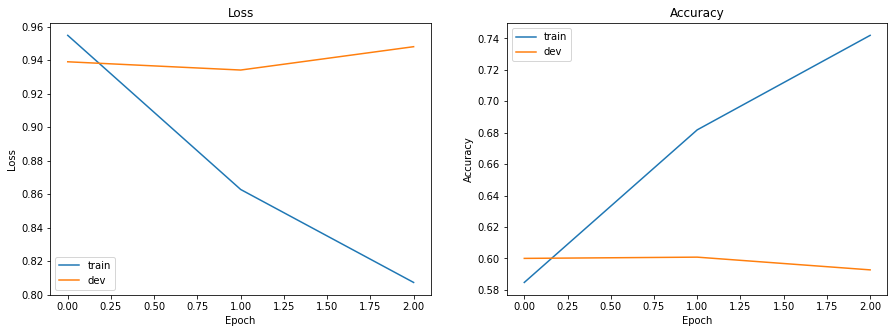

In [ ]:
# plot the loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(train_losses, label='train')
ax[0].plot(dev_losses, label='dev')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].title.set_text('Loss')
ax[0].legend()
ax[1].plot(train_accs, label='train')
ax[1].plot(dev_accs, label='dev')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].title.set_text('Accuracy')
ax[1].legend()
plt.show()


In [ ]:
# confusion matrix and classification report
y_true = []
y_pred = []
with torch.no_grad():
    for images, texts, labels in tqdm(test_dataloader_tokenized):
        images = images.to(device)
        labels = labels.to(device)
        texts = texts.to(device)
        # get the image and text embeddings
        image_embeddings = image_encoder(images)
        text_embeddings = text_encoder(texts)
        # concatenate the image and text embeddings
        embeddings = torch.cat((image_embeddings, text_embeddings), dim=1)
        # get the predictions
        predictions = classifier(embeddings)
        # get the labels
        y_true.extend(labels.tolist())
        y_pred.extend(predictions.argmax(dim=1).tolist())

100%|██████████| 159/159 [01:31<00:00,  1.75it/s]


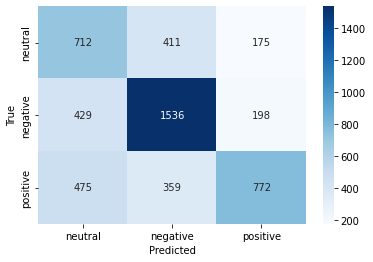




              precision    recall  f1-score   support

     neutral       0.44      0.55      0.49      1298
    negative       0.67      0.71      0.69      2163
    positive       0.67      0.48      0.56      1606

    accuracy                           0.60      5067
   macro avg       0.59      0.58      0.58      5067
weighted avg       0.61      0.60      0.60      5067



In [ ]:
# confusion matrix
cm = sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['neutral', 'negative', 'positive'], yticklabels=['neutral', 'negative', 'positive'])
cm.set_xlabel('Predicted')
cm.set_ylabel('True')
plt.show()
# classification report
print('\n\n')
print(classification_report(y_true, y_pred, target_names=['neutral', 'negative', 'positive']))

### Using Face Features
We used MTCNN to extract faces from the images, then pass the cropped images to InceptionResnetV1 with pretrained 'vggface2' weights which embeds each face to a 512 dimensional vector. We then average these embeddings for images with multiple faces and use an all zeros 512 dimensional vector for images with no detected faces. We then concatenate these image embeddings with BERT output and pass it to a Multi-Layer Perceptron.

In [ ]:
# define an image transform that resizes the input to 640x1280 and reshape to (H, W, C)
image_transform = transforms.Compose([
    transforms.Resize((640, 1280)),
    torchvision.transforms.Lambda(lambda x: x.permute(1, 2, 0))
])
# change the image transform of the dataset
MSCTD_train.image_transform = image_transform
MSCTD_dev.image_transform = image_transform
MSCTD_test.image_transform = image_transform

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(image_size=160, margin=0, min_face_size=20, thresholds=[0.8, 0.9, 0.9], keep_all=True, device=device)
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

# define text encoder
text_encoder = TextEncoder(is_trainable=True).to(device)

# define the classifier
classifier = MLPClassifier(512+768, 512, 3).to(device)

# define the optimizer
optimizer = optim.Adam(list(classifier.parameters()) + list(text_encoder.parameters()), lr=1e-5)

  0%|          | 0.00/107M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_losses = []
dev_losses = []
train_accs = []
dev_accs = []
num_epochs = 2
for epoch in range(num_epochs):
    # train
    train_loss = 0
    train_acc = 0
    total_samples = 0
    for images, texts, labels in tqdm(train_dataloader_tokenized):
        # crop face images
        image_cropped = mtcnn(images)
        # average embeddings over images with multiple faces and zero for images with no face
        image_embeddings = torch.stack([torch.mean(resnet(image.to(device)), dim=0) if image is not None else torch.zeros(512).to(device) for image in image_cropped])
        labels = labels.to(device)
        texts = texts.to(device)
        # get the text embeddings
        text_embeddings = text_encoder(texts)
        # concatenate the image and text embeddings
        embeddings = torch.cat((image_embeddings, text_embeddings), dim=1)
        # get the predictions
        predictions = classifier(embeddings)
        # calculate the loss
        loss = F.cross_entropy(predictions, labels)
        # calculate the accuracy
        acc = (predictions.argmax(dim=1) == labels).float().sum()
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # update the loss and accuracy
        train_loss += loss.item()
        train_acc += acc.item()
        total_samples += labels.size(0)
    # calculate the average loss and accuracy
    train_loss /= len(train_dataloader_tokenized)
    train_acc /= total_samples
    # save the loss and accuracy
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # evaluate
    dev_loss = 0
    dev_acc = 0
    total_samples = 0
    with torch.no_grad():
        for images, texts, labels in tqdm(dev_dataloader_tokenized):
            # crop face images
            image_cropped = mtcnn(images)
            # average embeddings over images with multiple faces and zero for images with no face
            image_embeddings = torch.stack([torch.mean(resnet(image.to(device)), dim=0) if image is not None else torch.zeros(512).to(device) for image in image_cropped])
            labels = labels.to(device)
            texts = texts.to(device)
            # get the text embeddings
            text_embeddings = text_encoder(texts)
            # concatenate the image and text embeddings
            embeddings = torch.cat((image_embeddings, text_embeddings), dim=1)
            # get the predictions
            predictions = classifier(embeddings)
            # calculate the loss
            loss = F.cross_entropy(predictions, labels)
            # calculate the accuracy
            acc = (predictions.argmax(dim=1) == labels).float().sum()
            # update the loss and accuracy
            dev_loss += loss.item()
            dev_acc += acc.item()
            total_samples += labels.size(0)
    # calculate the average loss and accuracy
    dev_loss /= len(dev_dataloader_tokenized)
    dev_acc /= total_samples
    # save the loss and accuracy
    dev_losses.append(dev_loss)
    dev_accs.append(dev_acc)

    # print the loss and accuracy
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Dev Loss: {dev_loss:.4f}, Dev Acc: {dev_acc:.4f}')

100%|██████████| 159/159 [07:09<00:00,  2.70s/it]


Epoch 1/2, Train Loss: 0.9497, Train Acc: 0.5907, Dev Loss: 0.9362, Dev Acc: 0.6018


100%|██████████| 159/159 [07:15<00:00,  2.74s/it]

Epoch 2/2, Train Loss: 0.8623, Train Acc: 0.6831, Dev Loss: 0.9359, Dev Acc: 0.6044


In [ ]:
# confusion matrix and classification report
y_true = []
y_pred = []
with torch.no_grad():
    for images, texts, labels in tqdm(test_dataloader_tokenized):
        labels = labels.to(device)
        texts = texts.to(device)
        # crop face images
        image_cropped = mtcnn(images)
        # average embeddings over images with multiple faces and zero for images with no face
        image_embeddings = torch.stack([torch.mean(resnet(image.to(device)), dim=0) if image is not None else torch.zeros(512).to(device) for image in image_cropped])
        # get the text embeddings
        text_embeddings = text_encoder(texts)
        # concatenate the image and text embeddings
        embeddings = torch.cat((image_embeddings, text_embeddings), dim=1)
        # get the predictions
        predictions = classifier(embeddings)
        # get the labels
        y_true.extend(labels.tolist())
        y_pred.extend(predictions.argmax(dim=1).tolist())

100%|██████████| 159/159 [07:25<00:00,  2.80s/it]


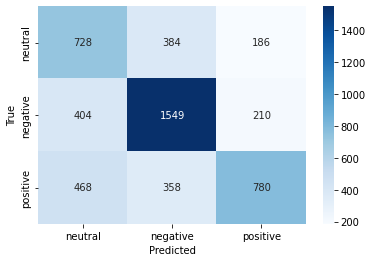




              precision    recall  f1-score   support

     neutral       0.46      0.56      0.50      1298
    negative       0.68      0.72      0.70      2163
    positive       0.66      0.49      0.56      1606

    accuracy                           0.60      5067
   macro avg       0.60      0.59      0.59      5067
weighted avg       0.62      0.60      0.60      5067



In [ ]:
# confusion matrix
cm = sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['neutral', 'negative', 'positive'], yticklabels=['neutral', 'negative', 'positive'])
cm.set_xlabel('Predicted')
cm.set_ylabel('True')
plt.show()
# classification report
print('\n\n')
print(classification_report(y_true, y_pred, target_names=['neutral', 'negative', 'positive']))

## Part 1 Subpart 2

### Using ViT as backbone for images and BERT as backbone for text
We concatenated the head of each backbone and trained an MLP on top of it

In [ ]:
# define a image_encoder model using resnet50 on timm
class ViTEncoder(nn.Module):
    def __init__(self, is_trainable=True):
        super(ViTEncoder, self).__init__()
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.vit.head = nn.Identity()
        if not is_trainable:
            for param in self.vit.parameters():
                param.requires_grad = False

    def forward(self, x):
        return self.vit(x)

In [ ]:
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# change the image transform of the dataset
MSCTD_train.image_transform = image_transform
MSCTD_dev.image_transform = image_transform
MSCTD_test.image_transform = image_transform

# define image_encoder and text_encoder
image_encoder = ViTEncoder(is_trainable=True).to(device)
text_encoder = TextEncoder(is_trainable=True).to(device)

# define the classifier
classifier = MLPClassifier(768, 512, 3).to(device)

# define the optimizer
optimizer = optim.Adam(list(text_encoder.parameters()) + list(classifier.parameters()) + list(image_encoder.parameters()), lr=1e-5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_losses = []
dev_losses = []
train_accs = []
dev_accs = []
num_epochs = 3
for epoch in range(num_epochs):
    # train
    train_loss = 0
    train_acc = 0
    total_samples = 0
    for images, texts, labels in tqdm(train_dataloader_tokenized):
        images = images.to(device)
        labels = labels.to(device)
        texts = texts.to(device)
        # get the image and text embeddings
        image_embeddings = image_encoder(images)
        text_embeddings = text_encoder(texts)
        # concatenate the image and text embeddings
        embeddings = torch.cat((image_embeddings.unsqueeze(1), text_embeddings.unsqueeze(1)), dim=1)
        embeddings = torch.max(embeddings, dim=1)[0]
        # get the predictions
        predictions = classifier(embeddings)
        # calculate the loss
        loss = F.cross_entropy(predictions, labels)
        # calculate the accuracy
        acc = (predictions.argmax(dim=1) == labels).float().sum()
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # update the loss and accuracy
        train_loss += loss.item()
        train_acc += acc.item()
        total_samples += labels.size(0)
    # calculate the average loss and accuracy
    train_loss /= len(train_dataloader_tokenized)
    train_acc /= total_samples
    # save the loss and accuracy
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    # evaluate
    dev_loss = 0
    dev_acc = 0
    total_samples = 0
    with torch.no_grad():
        for images, texts, labels in tqdm(dev_dataloader_tokenized):
            images = images.to(device)
            labels = labels.to(device)
            texts = texts.to(device)
            # get the image and text embeddings
            image_embeddings = image_encoder(images)
            text_embeddings = text_encoder(texts)
            # concatenate the image and text embeddings
            embeddings = torch.cat((image_embeddings.unsqueeze(1), text_embeddings.unsqueeze(1)), dim=1)
            embeddings = torch.max(embeddings, dim=1)[0]
            # get the predictions
            predictions = classifier(embeddings)
            # calculate the loss
            loss = F.cross_entropy(predictions, labels)
            # calculate the accuracy
            acc = (predictions.argmax(dim=1) == labels).float().sum()
            # update the loss and accuracy
            dev_loss += loss.item()
            dev_acc += acc.item()
            total_samples += labels.size(0)
    # calculate the average loss and accuracy
    dev_loss /= len(dev_dataloader_tokenized)
    dev_acc /= total_samples
    # save the loss and accuracy
    dev_losses.append(dev_loss)
    dev_accs.append(dev_acc)
    # print the loss and accuracy
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Dev Loss: {dev_loss:.4f}, Dev Acc: {dev_acc:.4f}')

100%|██████████| 159/159 [01:57<00:00,  1.36it/s]


Epoch 1/3, Train Loss: 0.9568, Train Acc: 0.5781, Dev Loss: 0.9323, Dev Acc: 0.6022


100%|██████████| 159/159 [01:56<00:00,  1.37it/s]


Epoch 2/3, Train Loss: 0.8608, Train Acc: 0.6844, Dev Loss: 0.9360, Dev Acc: 0.6030


100%|██████████| 159/159 [01:55<00:00,  1.38it/s]

Epoch 3/3, Train Loss: 0.8082, Train Acc: 0.7390, Dev Loss: 0.9398, Dev Acc: 0.6010


In [ ]:
# confusion matrix and classification report
y_true = []
y_pred = []
with torch.no_grad():
    for images, texts, labels in tqdm(test_dataloader_tokenized):
        images = images.to(device)
        labels = labels.to(device)
        texts = texts.to(device)
        # get the image and text embeddings
        image_embeddings = image_encoder(images)
        text_embeddings = text_encoder(texts)
        # concatenate the image and text embeddings
        embeddings = torch.cat((image_embeddings.unsqueeze(1), text_embeddings.unsqueeze(1)), dim=1)
        embeddings = torch.max(embeddings, dim=1)[0]
        # get the predictions
        predictions = classifier(embeddings)
        # get the labels
        y_true.extend(labels.tolist())
        y_pred.extend(predictions.argmax(dim=1).tolist())

100%|██████████| 159/159 [02:04<00:00,  1.28it/s]


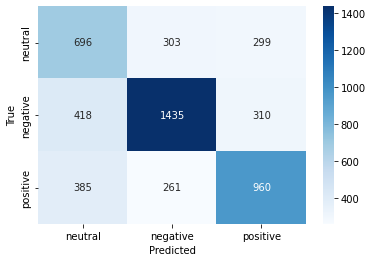




              precision    recall  f1-score   support

     neutral       0.46      0.54      0.50      1298
    negative       0.72      0.66      0.69      2163
    positive       0.61      0.60      0.60      1606

    accuracy                           0.61      5067
   macro avg       0.60      0.60      0.60      5067
weighted avg       0.62      0.61      0.61      5067



In [ ]:
# confusion matrix
cm = sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['neutral', 'negative', 'positive'], yticklabels=['neutral', 'negative', 'positive'])
cm.set_xlabel('Predicted')
cm.set_ylabel('True')
plt.show()
# classification report
print('\n\n')
print(classification_report(y_true, y_pred, target_names=['neutral', 'negative', 'positive']))

# Part 2

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# tokenize datasets
max_length = 25
tokenized_train = TokenizedDataset(MSCTD_train, tokenizer, max_length)
tokenized_dev = TokenizedDataset(MSCTD_dev, tokenizer, max_length)
tokenized_test = TokenizedDataset(MSCTD_test, tokenizer, max_length)

# dataloader
train_dataloader_tokenized = DataLoader(tokenized_train, batch_size=32, shuffle=True)
dev_dataloader_tokenized = DataLoader(tokenized_dev, batch_size=32, shuffle=True)
test_dataloader_tokenized = DataLoader(tokenized_test, batch_size=32, shuffle=True)

# define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
# define a new class for image encoder that gets image encoder as input and adds a linear layer on top of it
class ImageEncoderWithLinearLayer(nn.Module):
    def __init__(self, is_trainable=True):
        super(ImageEncoderWithLinearLayer, self).__init__()
        self.image_encoder = ImageEncoder(is_trainable=True)
        self.linear_layer = nn.Linear(2048, 3)

    def forward(self, x):
        x = self.image_encoder(x)
        x = self.linear_layer(x)
        return x

# define a new class for text encoder that gets text encoder as input and adds a linear layer on top of it
class TextEncoderWithLinearLayer(nn.Module):
    def __init__(self, is_trainable=True):
        super(TextEncoderWithLinearLayer, self).__init__()
        self.text_encoder = TextEncoder(is_trainable=True)
        self.linear_layer = nn.Linear(768, 3)

    def forward(self, x):
        x = self.text_encoder(x)
        x = self.linear_layer(x)
        return x

image_encoder = ImageEncoderWithLinearLayer().to(device)
image_optimizer = optim.Adam(image_encoder.parameters(), lr=1e-5)
text_encoder = TextEncoderWithLinearLayer().to(device)
text_optimizer = optim.Adam(text_encoder.parameters(), lr=1e-5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Training on image

In [18]:
train_losses = []
dev_losses = []
train_accs = []
dev_accs = []
num_epochs = 3
for epoch in range(num_epochs):
    # train
    train_loss = 0
    train_acc = 0
    total_samples = 0
    for images, _, labels in tqdm(train_dataloader_tokenized):
        images = images.to(device)
        labels = labels.to(device)
        # get the image embeddings
        predictions = image_encoder(images)
        # calculate the loss
        loss = F.cross_entropy(predictions, labels)
        # calculate the accuracy
        acc = (predictions.argmax(dim=1) == labels).float().sum()
        # backpropagation
        image_optimizer.zero_grad()
        loss.backward()
        image_optimizer.step()
        # update the loss and accuracy
        train_loss += loss.item()
        train_acc += acc.item()
        total_samples += labels.size(0)
    # calculate the average loss and accuracy
    train_loss /= len(train_dataloader_tokenized)
    train_acc /= total_samples
    # save the loss and accuracy
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    # evaluate
    dev_loss = 0
    dev_acc = 0
    total_samples = 0
    with torch.no_grad():
        for images, _, labels in tqdm(dev_dataloader_tokenized):
            images = images.to(device)
            labels = labels.to(device)
            # get the image embeddings
            predictions = image_encoder(images)
            # calculate the loss
            loss = F.cross_entropy(predictions, labels)
            # calculate the accuracy
            acc = (predictions.argmax(dim=1) == labels).float().sum()
            # update the loss and accuracy
            dev_loss += loss.item()
            dev_acc += acc.item()
            total_samples += labels.size(0)
    # calculate the average loss and accuracy
    dev_loss /= len(dev_dataloader_tokenized)
    dev_acc /= total_samples
    # save the loss and accuracy
    dev_losses.append(dev_loss)
    dev_accs.append(dev_acc)
    # print the loss and accuracy
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Dev Loss: {dev_loss:.4f}, Dev Acc: {dev_acc:.4f}')

100%|██████████| 159/159 [01:19<00:00,  2.01it/s]


Epoch 1/3, Train Loss: 1.0899, Train Acc: 0.3838, Dev Loss: 1.0954, Dev Acc: 0.3624


100%|██████████| 159/159 [01:15<00:00,  2.11it/s]


Epoch 2/3, Train Loss: 1.0849, Train Acc: 0.3917, Dev Loss: 1.0967, Dev Acc: 0.3636


100%|██████████| 159/159 [01:30<00:00,  1.76it/s]

Epoch 3/3, Train Loss: 1.0821, Train Acc: 0.3967, Dev Loss: 1.0952, Dev Acc: 0.3632


In [19]:
torch.save(image_encoder, 'image_backbone.pth')

### Training on text

In [20]:
train_losses = []
dev_losses = []
train_accs = []
dev_accs = []
num_epochs = 2
for epoch in range(num_epochs):
    # train
    train_loss = 0
    train_acc = 0
    total_samples = 0
    for ـ, texts, labels in tqdm(train_dataloader_tokenized):
        texts = texts.to(device)
        labels = labels.to(device)
        # get the image embeddings
        predictions = text_encoder(texts)
        # calculate the loss
        loss = F.cross_entropy(predictions, labels)
        # calculate the accuracy
        acc = (predictions.argmax(dim=1) == labels).float().sum()
        # backpropagation
        text_optimizer.zero_grad()
        loss.backward()
        text_optimizer.step()
        # update the loss and accuracy
        train_loss += loss.item()
        train_acc += acc.item()
        total_samples += labels.size(0)
    # calculate the average loss and accuracy
    train_loss /= len(train_dataloader_tokenized)
    train_acc /= total_samples
    # save the loss and accuracy
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    # evaluate
    dev_loss = 0
    dev_acc = 0
    total_samples = 0
    with torch.no_grad():
        for _, texts, labels in tqdm(dev_dataloader_tokenized):
            texts = texts.to(device)
            labels = labels.to(device)
            # get the image embeddings
            predictions = text_encoder(texts)
            # calculate the loss
            loss = F.cross_entropy(predictions, labels)
            # calculate the accuracy
            acc = (predictions.argmax(dim=1) == labels).float().sum()
            # update the loss and accuracy
            dev_loss += loss.item()
            dev_acc += acc.item()
            total_samples += labels.size(0)
    # calculate the average loss and accuracy
    dev_loss /= len(dev_dataloader_tokenized)
    dev_acc /= total_samples
    # save the loss and accuracy
    dev_losses.append(dev_loss)
    dev_accs.append(dev_acc)
    # print the loss and accuracy
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Dev Loss: {dev_loss:.4f}, Dev Acc: {dev_acc:.4f}')

100%|██████████| 159/159 [01:04<00:00,  2.46it/s]


Epoch 1/2, Train Loss: 0.8716, Train Acc: 0.6035, Dev Loss: 0.8605, Dev Acc: 0.6048


100%|██████████| 159/159 [01:04<00:00,  2.46it/s]

Epoch 2/2, Train Loss: 0.6848, Train Acc: 0.7098, Dev Loss: 0.8902, Dev Acc: 0.6014


In [21]:
torch.save(text_encoder, 'text_backbone.pth')

### Weakly Supervised Learning on COCO

In [26]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip -q annotations_trainval2014.zip
!wget http://images.cocodataset.org/zips/train2014.zip
!unzip -q train2014.zip
!rm -f train2014.zip
!rm -f annotations_trainval2014.zip

--2023-02-11 07:46:19--  http://images.cocodataset.org/annotations/annotations_trainval2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.16.2, 52.217.133.185, 52.217.133.1, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.16.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252872794 (241M) [application/zip]
Saving to: ‘annotations_trainval2014.zip’

annotations_trainva 100%[===================>] 241.16M  33.4MB/s    in 8.3s    

2023-02-11 07:46:28 (29.1 MB/s) - ‘annotations_trainval2014.zip’ saved [252872794/252872794]

--2023-02-11 07:46:36--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.98.116, 52.216.42.169, 54.231.135.33, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.98.116|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘train2014.zip’

train

In [27]:
class COCOPeopleDataset(Dataset):
    def __init__(self, annFile, captions_path, transforms=None):
        self.coco = COCO(annFile)
        self.coco_caps = COCO(captions_path)
        self.imgIds = self.coco.getImgIds(catIds=self.coco.getCatIds(catNms=['person']))
        self.transforms = transforms

        self.text = []
        for idx in range(len(self.imgIds)):
            img = self.coco.loadImgs(self.imgIds[idx])[0]
            annIds = self.coco_caps.getAnnIds(imgIds=img['id'])
            anns = self.coco_caps.loadAnns(annIds)
            self.text.append(anns[0]['caption'])

    def __len__(self):
        return len(self.imgIds)

    def __getitem__(self, idx):
        img = self.coco.loadImgs(self.imgIds[idx])[0]
        path = os.path.join('train2014/', img['file_name'])
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype(np.float32) / 255.0
        caption = self.text[idx]

        if self.transforms is not None:
            image = self.transforms(image)

        return image, caption


# Apply desired transformations
image_transform = transforms.Compose([transforms.ToTensor(), 
                                      transforms.Resize((224, 224)), 
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Create the dataset
coco_dataset = COCOPeopleDataset(annFile='/content/annotations/instances_train2014.json',captions_path='/content/annotations/captions_train2014.json', transforms=image_transform)
     

loading annotations into memory...
Done (t=16.49s)
creating index...
index created!
loading annotations into memory...
Done (t=0.91s)
creating index...
index created!


In [28]:
def get_wordnet_pos(word):
    """Map POS tag to first character used by WordNetLemmatizer"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def text_preprocessor(dataset):
      # preprocess text
      dataset.text = [preprocess_text(text) for text in dataset.text]

def preprocess_text(text):
      # Replace contractions with original text
  text = re.sub(r'(\b[Aa]in\'t\b)', "am not", text)
  text = re.sub(r'(\b[Hh]a\'t\b)', "has", text)
  text = re.sub(r'(\b[Ii]\'m\b)', "i am", text)
  text = re.sub(r'(\b\'s\b)', " is", text)
  text = re.sub(r'(\b\'re\b)', " are", text)
  text = re.sub(r'(\b\'ve\b)', " have", text)
  text = re.sub(r'(\b\'d\b)', " would", text)
  text = re.sub(r'(\b\'ll\b)', " will", text)
  text = re.sub(r'(\b[Ss]han\'t\b)', "shall not", text)
  text = re.sub(r'(\b[Ww]on\'t\b)', "will not", text)
  text = re.sub(r'(\b[Ww]ouldn\'t\b)', "would not", text)
  text = re.sub(r'(\b[Dd]on\'t\b)', "do not", text)
  text = re.sub(r'(\b[Cc]an\'t\b)', "can not", text)
  text = re.sub(r'(\b[Ii]s\'nt\b)', "is not", text)
  text = re.sub(r'(\b[Ww]eren\'t\b)', "were not", text)
  text = re.sub(r'(\b[Hh]aven\'t\b)', "have not", text)
  text = re.sub(r'(\b[Hh]adn\'t\b)', "had not", text)
  text = re.sub(r'(\b[Hh]asn\'t\b)', "has not", text)
  text = re.sub(r'(\b[Hh]adn\'t\b)', "had not", text)
  text = re.sub(r'(\b[Dd]idn\'t\b)', "did not", text)

  # Remove punctuation
  text = text.translate(str.maketrans("", "", string.punctuation))

  # Convert to lowercase
  text = text.lower()

  # Tokenize text
  tokens = word_tokenize(text)

  # Remove stop words
  # tokens = [token for token in tokens if token not in stop_words]
  # Remove numbers
  tokens = [token for token in tokens if token.isalpha()]

  # Lemmatize tokens
  tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]

  return ' '.join(tokens)

# Test the TextPreprocessor
text_preprocessor(coco_dataset)

In [29]:
# define a class that get a dataset and return tokenized dataset
class TokenizedCoco(Dataset):
    def __init__(self, dataset, tokenizer, max_length=80):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __getitem__(self, index):
        image, text = self.dataset[index]
        text = self.tokenizer.encode_plus(text, add_special_tokens=True, max_length=self.max_length, 
                                          padding='max_length', truncation=True, return_tensors='pt')
        return image, text
    def __len__(self):
        return len(self.dataset)

In [30]:
coco_dataset_tokenized = TokenizedCoco(coco_dataset, tokenizer, max_length=25)
coco_dataloader_tokenized = DataLoader(coco_dataset_tokenized, batch_size=32, shuffle=True)
image_optimizer = optim.Adam(image_encoder.parameters(), lr=1e-5)

In [ ]:
train_losses = []
dev_losses = []
train_accs = []
dev_accs = []
num_epochs = 3
for epoch in range(num_epochs):
    # train
    train_loss = 0
    train_acc = 0
    total_samples = 0
    for images, texts in tqdm(coco_dataloader_tokenized):
        images = images.to(device)
        texts = texts.to(device)
        labels = labels.to(device)
        # get the pseudo labels from text encoder
        labels = text_encoder(texts)
        # get predictions from image encoder
        predictions = image_encoder(images)
        # calculate the loss
        loss = F.cross_entropy(predictions, labels)
        # calculate the accuracy
        acc = (predictions.argmax(dim=1) == labels.argmax(dim=1)).float().sum()
        # backpropagation
        image_optimizer.zero_grad()
        loss.backward()
        image_optimizer.step()
        # update the loss and accuracy
        train_loss += loss.item()
        train_acc += acc.item()
        total_samples += labels.size(0)
    # calculate the average loss and accuracy
    train_loss /= len(train_dataloader_tokenized)
    train_acc /= total_samples
    # save the loss and accuracy
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    # print the loss and accuracy
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')

 27%|██▋       | 379/1412 [05:23<13:04,  1.32it/s]